In [1]:
import pandas as pd
import numpy as np
import ast
import psutil
from gensim.models import Word2Vec
from tqdm import tqdm
import plotly_express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score
from sklearn import datasets
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import dendrogram

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer


import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # Import the Axes3D module

import seaborn as sns

pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings("ignore")

In [2]:
athens_weekdays = pd.read_csv(r"athens_weekdays.csv")
athens_weekends = pd.read_csv(r'athens_weekends.csv')

In [3]:
athens_weekdays.shape

(2653, 20)

In [4]:
athens_weekends.shape

(2627, 20)

In [5]:
merged_df = pd.merge(athens_weekdays, athens_weekends, how='outer')
merged_df.shape

(5280, 20)

In [6]:
merged_df.isnull().sum().sum()

0

In [7]:
merged_df.replace({True: 1, False: 0}, inplace=True)

In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5280 entries, 0 to 5279
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  5280 non-null   int64  
 1   realSum                     5280 non-null   float64
 2   room_type                   5280 non-null   object 
 3   room_shared                 5280 non-null   int64  
 4   room_private                5280 non-null   int64  
 5   person_capacity             5280 non-null   float64
 6   host_is_superhost           5280 non-null   int64  
 7   multi                       5280 non-null   int64  
 8   biz                         5280 non-null   int64  
 9   cleanliness_rating          5280 non-null   float64
 10  guest_satisfaction_overall  5280 non-null   float64
 11  bedrooms                    5280 non-null   int64  
 12  dist                        5280 non-null   float64
 13  metro_dist                  5280 

In [9]:
columns_to_drop = ['attr_index_norm', "rest_index_norm", 'Unnamed: 0', 'multi', 'biz']

In [10]:
merged_df.drop(columns=columns_to_drop, inplace=True)
merged_df.drop(index=4137, inplace=True)

In [11]:
merged_df.shape

(5279, 15)

In [12]:
merged_df_dummies = pd.get_dummies(merged_df, columns=['room_type'], prefix='Category')
merged_df_dummies

,realSum,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat,Category_Entire home/apt,Category_Private room,Category_Shared room
0,129.824479,0,0,4.0,0,10.0,100.0,2,2.813964,0.881890,55.348572,78.778377,23.76600,37.98300,1,0,0
1,138.963748,0,0,4.0,1,10.0,96.0,1,0.407293,0.304568,240.306654,407.167696,23.73168,37.97776,1,0,0
2,156.304923,0,0,3.0,1,10.0,98.0,1,1.237211,0.288488,199.507366,395.967403,23.72200,37.97900,1,0,0
3,91.627024,0,0,4.0,1,10.0,99.0,1,4.367457,0.297467,39.803047,58.706578,23.72712,38.01435,1,0,0
4,74.051508,0,1,2.0,0,10.0,100.0,1,2.194185,0.385266,78.733405,113.325973,23.73391,37.99529,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,74.051508,0,0,3.0,1,10.0,98.0,1,3.311976,1.856865,49.097725,71.119758,23.75000,38.00306,1,0,0
5276,295.737351,0,0,4.0,1,10.0,100.0,1,1.800556,0.571033,146.240703,203.884287,23.71500,37.97400,1,0,0
5277,169.193635,0,0,4.0,1,10.0,99.0,2,3.845100,0.786416,42.260382,60.948754,23.76657,37.99986,1,0,0
5278,160.991728,0,0,4.0,1,10.0,100.0,1,4.827460,0.141952,35.700540,52.659912,23.73300,38.01900,1,0,0


In [13]:
merged_df_dummies.drop(['lng', 'lat'], axis=1, inplace=True)

In [14]:
ss = StandardScaler()

'''fit scaler on numeric features'''
ss.fit(merged_df_dummies)

'''scale numeric features'''
X = ss.transform(merged_df_dummies)
X

array([[-0.08241373, -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ],
       [-0.04804   , -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ],
       [ 0.01718194, -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ],
       ...,
       [ 0.0656577 , -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ],
       [ 0.03480949, -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ],
       [ 0.15291408, -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ]])

In [15]:
model_kmeans = KMeans(n_clusters=5, random_state=51).fit(X)
model_kmeans

KMeans(n_clusters=5, random_state=51)

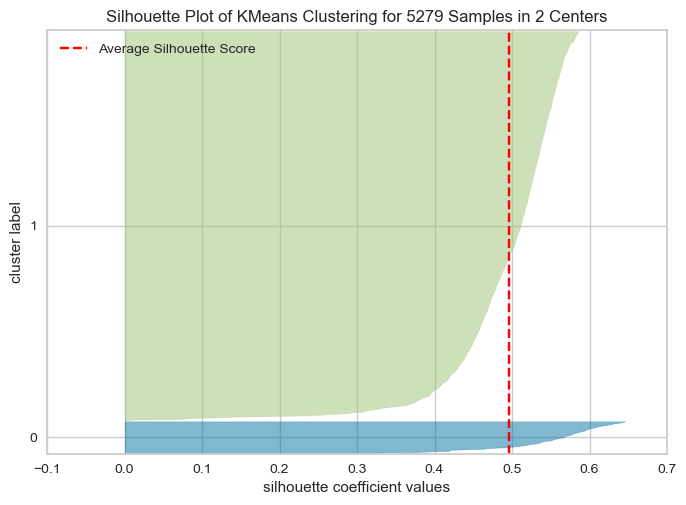

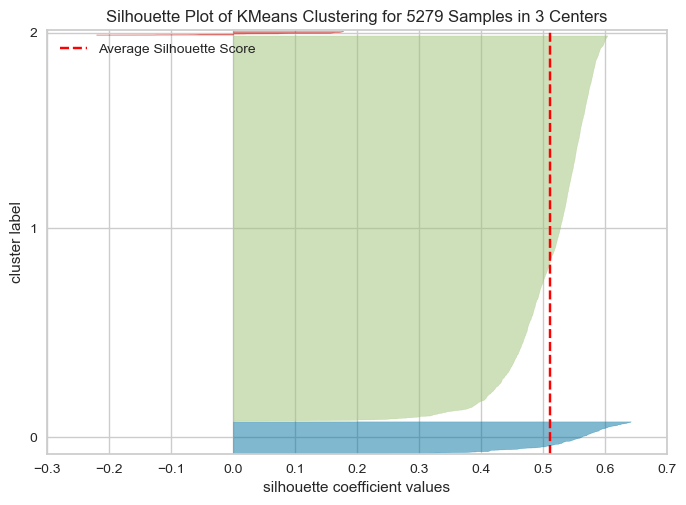

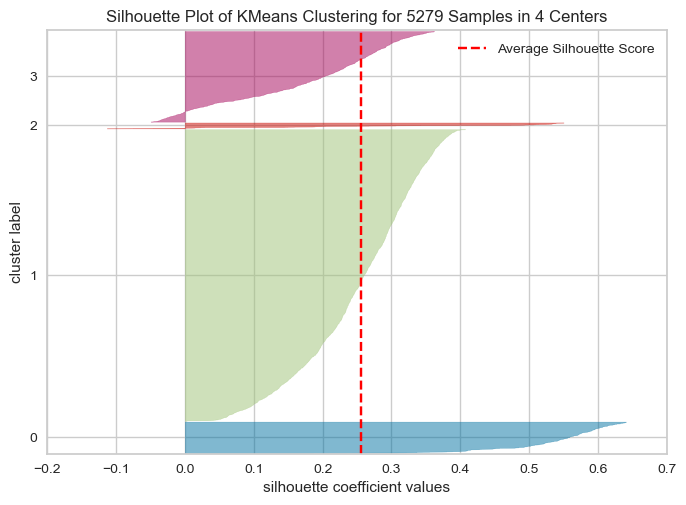

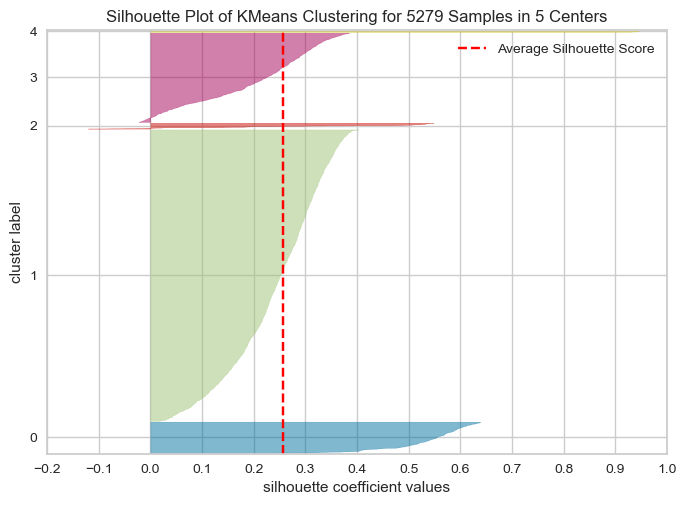

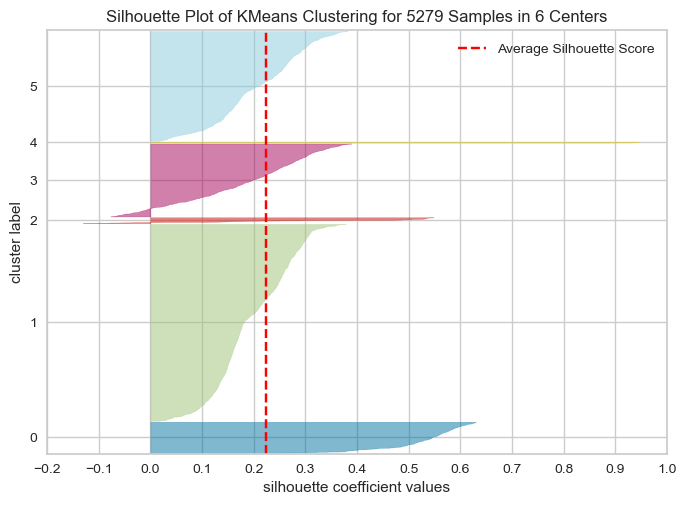

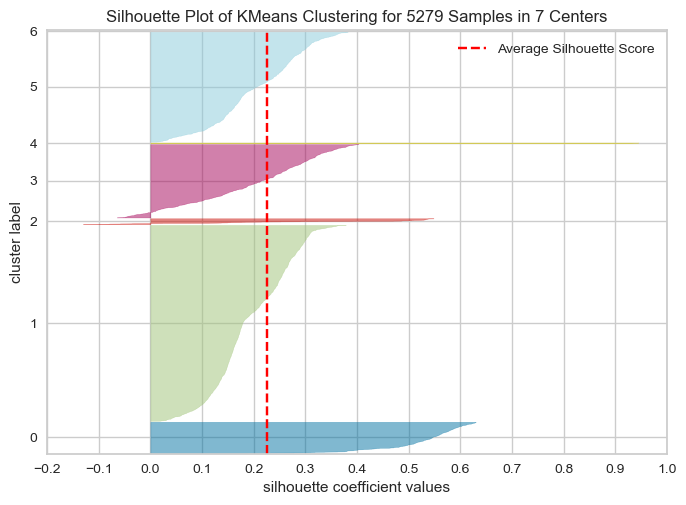

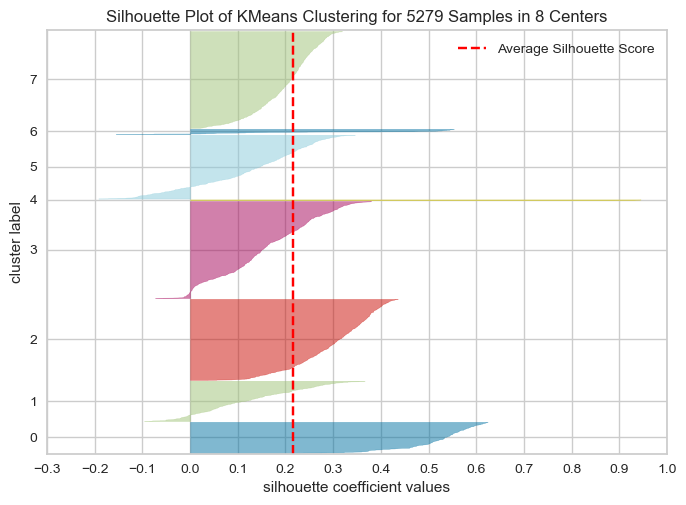

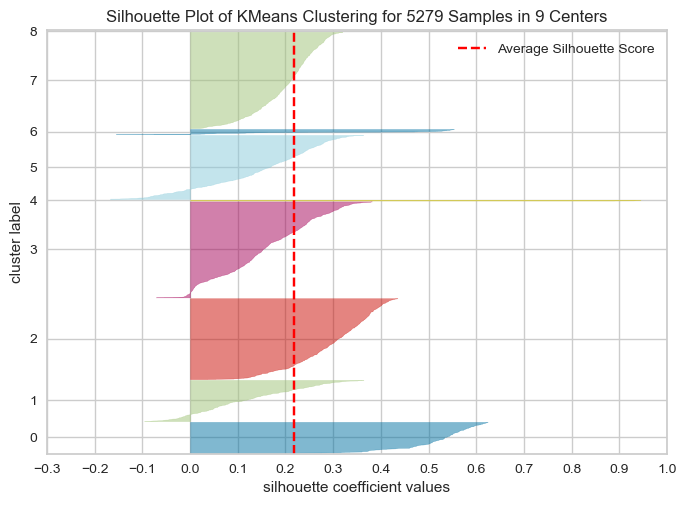

In [16]:
sillhouette_list= []
for i in range(2,10):  
    model_kmeans = KMeans(n_clusters=i, random_state=51).fit(X)
    visualizer = SilhouetteVisualizer(model_kmeans, colors='yellowbrick')
    visualizer.fit(X)
    silhouette_avg = silhouette_score(X, model_kmeans.labels_)
    visualizer.poof()
    sillhouette_list.append(silhouette_avg)

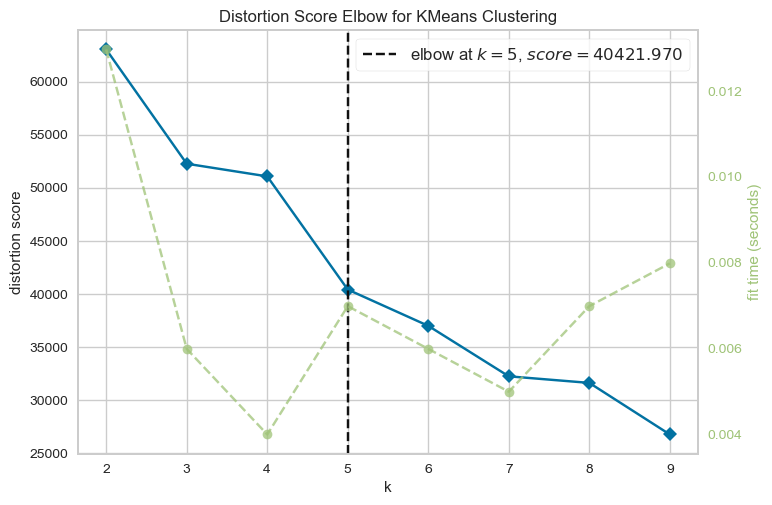

In [17]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), timings = True)

visualizer.fit(X)         # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

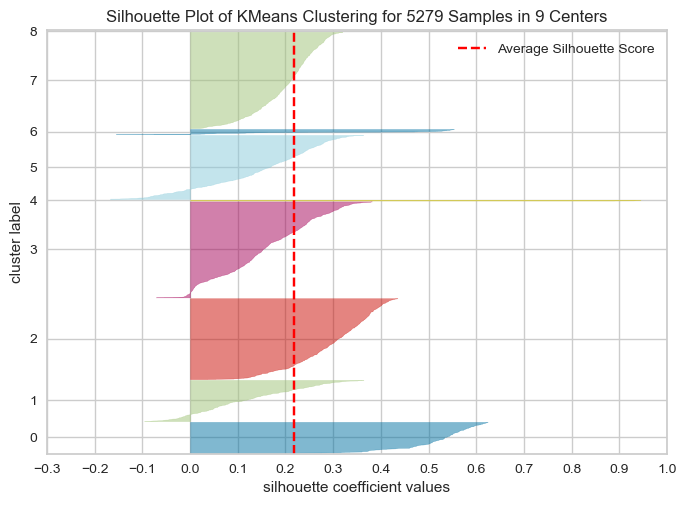

In [18]:
visualizer = SilhouetteVisualizer(model_kmeans, colors='yellowbrick')
visualizer.fit(X)
silhouette_avg = silhouette_score(X, model_kmeans.labels_)
visualizer.poof()
sillhouette_list.append(silhouette_avg)

In [19]:
df_predict = model_kmeans.predict(X)

In [20]:
merged_df['Clusters'] = df_predict

In [21]:
merged_df

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat,Clusters
0,129.824479,Entire home/apt,0,0,4.0,0,10.0,100.0,2,2.813964,0.881890,55.348572,78.778377,23.76600,37.98300,1
1,138.963748,Entire home/apt,0,0,4.0,1,10.0,96.0,1,0.407293,0.304568,240.306654,407.167696,23.73168,37.97776,5
2,156.304923,Entire home/apt,0,0,3.0,1,10.0,98.0,1,1.237211,0.288488,199.507366,395.967403,23.72200,37.97900,2
3,91.627024,Entire home/apt,0,0,4.0,1,10.0,99.0,1,4.367457,0.297467,39.803047,58.706578,23.72712,38.01435,2
4,74.051508,Private room,0,1,2.0,0,10.0,100.0,1,2.194185,0.385266,78.733405,113.325973,23.73391,37.99529,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,74.051508,Entire home/apt,0,0,3.0,1,10.0,98.0,1,3.311976,1.856865,49.097725,71.119758,23.75000,38.00306,1
5276,295.737351,Entire home/apt,0,0,4.0,1,10.0,100.0,1,1.800556,0.571033,146.240703,203.884287,23.71500,37.97400,2
5277,169.193635,Entire home/apt,0,0,4.0,1,10.0,99.0,2,3.845100,0.786416,42.260382,60.948754,23.76657,37.99986,3
5278,160.991728,Entire home/apt,0,0,4.0,1,10.0,100.0,1,4.827460,0.141952,35.700540,52.659912,23.73300,38.01900,2


In [22]:
merged_df.groupby('Clusters').median().reset_index()

,Clusters,realSum,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat
0,0,80.144354,0.0,1.0,2.0,0.0,10.0,96.0,1.0,1.722560,0.408148,111.065124,168.761278,23.728160,37.984980
1,1,108.968200,0.0,0.0,4.0,0.0,10.0,97.0,1.0,1.749973,1.031779,87.266954,122.064705,23.743000,37.988040
2,2,115.998406,0.0,0.0,3.0,1.0,10.0,98.0,1.0,1.822209,0.414815,116.888260,167.633242,23.729090,37.980000
3,3,150.680758,0.0,0.0,5.0,0.0,10.0,98.0,2.0,1.858096,0.423519,108.758710,156.532719,23.729000,37.982075
4,4,83.425117,1.0,0.0,2.0,0.0,9.0,94.0,1.0,2.094350,0.250314,110.913696,192.280361,23.712440,37.980370
5,5,197.080121,0.0,0.0,4.0,1.0,10.0,98.0,1.0,0.869209,0.336532,319.581030,494.413077,23.728845,37.974000
6,6,104.281396,0.0,0.0,4.0,0.0,5.0,40.0,1.0,2.020883,0.501496,83.281500,124.228054,23.734040,37.987380
7,7,113.420664,0.0,0.0,3.0,0.0,10.0,95.0,1.0,1.818298,0.389136,113.257924,169.309994,23.728050,37.980720
8,8,18545.450285,0.0,0.0,2.0,1.0,10.0,100.0,1.0,1.196536,0.381128,134.904353,275.573716,23.732000,37.986000


In [23]:
merged_df_dummies['Clusters']= df_predict

In [24]:
merged_df_dummies.groupby('Clusters').median().reset_index()

,Clusters,realSum,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,Category_Entire home/apt,Category_Private room,Category_Shared room
0,0,80.144354,0.0,1.0,2.0,0.0,10.0,96.0,1.0,1.722560,0.408148,111.065124,168.761278,0.0,1.0,0.0
1,1,108.968200,0.0,0.0,4.0,0.0,10.0,97.0,1.0,1.749973,1.031779,87.266954,122.064705,1.0,0.0,0.0
2,2,115.998406,0.0,0.0,3.0,1.0,10.0,98.0,1.0,1.822209,0.414815,116.888260,167.633242,1.0,0.0,0.0
3,3,150.680758,0.0,0.0,5.0,0.0,10.0,98.0,2.0,1.858096,0.423519,108.758710,156.532719,1.0,0.0,0.0
4,4,83.425117,1.0,0.0,2.0,0.0,9.0,94.0,1.0,2.094350,0.250314,110.913696,192.280361,0.0,0.0,1.0
5,5,197.080121,0.0,0.0,4.0,1.0,10.0,98.0,1.0,0.869209,0.336532,319.581030,494.413077,1.0,0.0,0.0
6,6,104.281396,0.0,0.0,4.0,0.0,5.0,40.0,1.0,2.020883,0.501496,83.281500,124.228054,1.0,0.0,0.0
7,7,113.420664,0.0,0.0,3.0,0.0,10.0,95.0,1.0,1.818298,0.389136,113.257924,169.309994,1.0,0.0,0.0
8,8,18545.450285,0.0,0.0,2.0,1.0,10.0,100.0,1.0,1.196536,0.381128,134.904353,275.573716,1.0,0.0,0.0


In [25]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=51)
tsne_X = tsne.fit_transform(X)
tsne_df = pd.DataFrame(tsne_X, columns=['t-SNE1', 't-SNE2', 't-SNE3'])
tsne_df['Target'] = df_predict

Text(0, 0.5, 't-SNE Component 2')

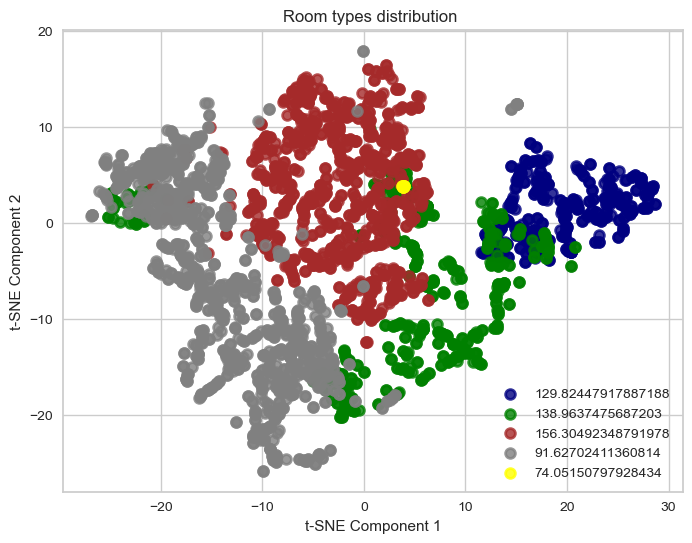

In [26]:
#Create a figure and an axes object
fig_tsne, ax_tsne = plt.subplots(figsize=(8, 6))
colors = ['navy', 'green', 'brown','grey','yellow']
lw = 2 #line width

#Plot on the axes object instead of using plt directly
for color ,i, target_name in zip(colors, [0, 1, 2,3,4], merged_df_dummies.realSum):
    ax_tsne.scatter(tsne_df.loc[tsne_df['Target'] == i, 't-SNE1'],
                    tsne_df.loc[tsne_df['Target'] == i, 't-SNE2'],
                    color=color, alpha=.8, lw=lw,
                    label=target_name)

ax_tsne.legend(loc='best', shadow=False, scatterpoints=1)
ax_tsne.set_title('Room types distribution ')
ax_tsne.set_xlabel('t-SNE Component 1')
ax_tsne.set_ylabel('t-SNE Component 2')

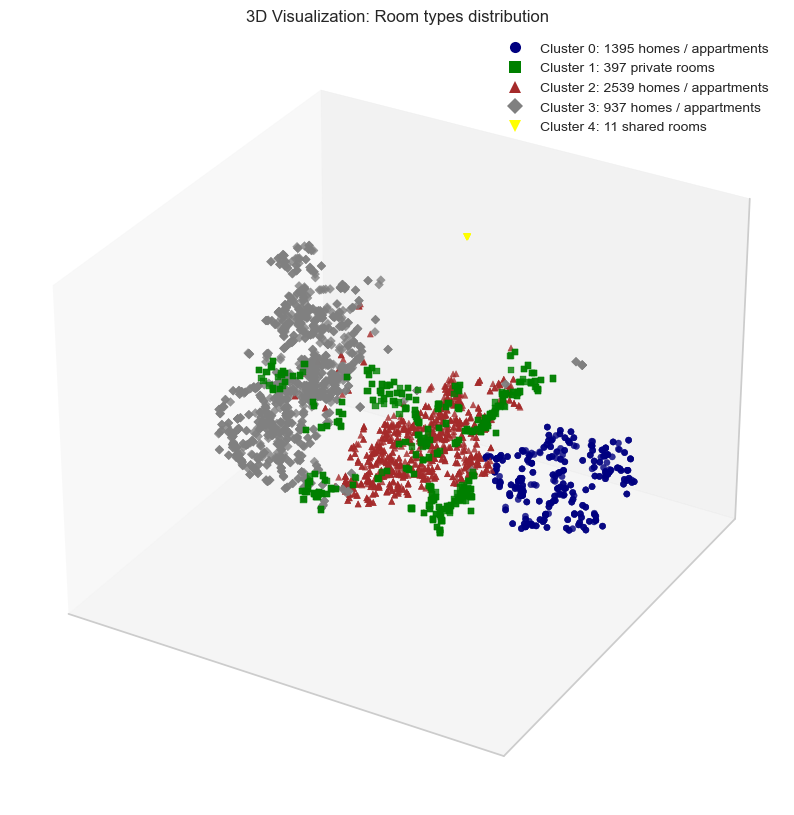

In [27]:
# Create a figure and an Axes3D object
fig_tsne_3d = plt.figure(figsize=(10, 30))
ax_tsne_3d = fig_tsne_3d.add_subplot(111, projection='3d')

# Define colors and markers for each target category
colors = ['navy', 'green', 'brown', 'grey', 'yellow']
markers = ['o', 's', '^', 'D', 'v']

# Plot on the 3D axes
for color, marker, i, target_name in zip(colors, markers, [0, 1, 2, 3, 4], merged_df_dummies.realSum):
    ax_tsne_3d.scatter(tsne_df.loc[tsne_df['Target'] == i, 't-SNE1'],
                       tsne_df.loc[tsne_df['Target'] == i, 't-SNE2'],
                       tsne_df.loc[tsne_df['Target'] == i, 't-SNE3'],
                       color=color, alpha=0.8, marker=marker,
                       label=target_name)

# Set plot title and labels
ax_tsne_3d.set_title('3D Visualization: Room types distribution')
ax_tsne_3d.set_xticks([])
ax_tsne_3d.set_yticks([])
ax_tsne_3d.set_zticks([])


# Add a custom legend
custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='navy', markersize=8),
                 plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=8),
                 plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='brown', markersize=8),
                 plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='grey', markersize=8),
                 plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='yellow', markersize=8)]

ax_tsne_3d.legend(custom_legend, ['Cluster 0: 1395 homes / appartments ', 'Cluster 1: 397 private rooms ', 'Cluster 2: 2539 homes / appartments', 'Cluster 3: 937 homes / appartments', 'Cluster 4: 11 shared rooms'], loc='best')

# Show the 3D plot
plt.show()

In [28]:
merged_df_dummies.groupby('Clusters')['room_private'].count().reset_index()

,Clusters,room_private
0,0,395
1,1,523
2,2,1028
3,3,1220
4,4,11
5,5,812
6,6,66
7,7,1223
8,8,1


In [29]:
mean_satisfaction= merged_df.groupby('host_is_superhost')['guest_satisfaction_overall'].mean().reset_index()

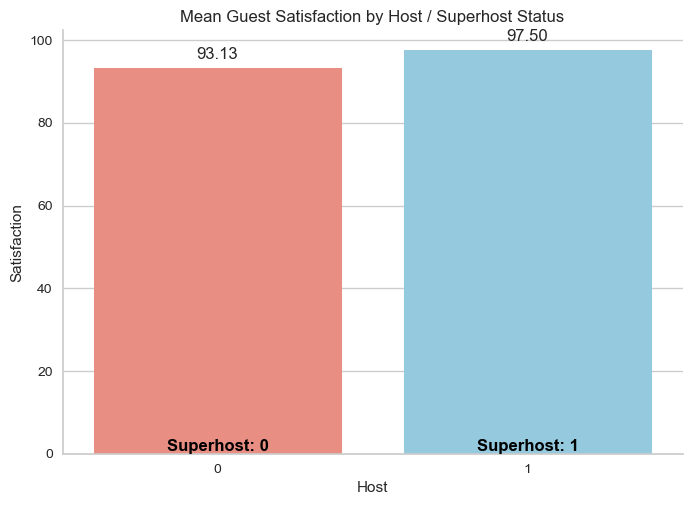

In [30]:
# Define custom colors for the bars
custom_palette = {'1': 'skyblue', '0': 'salmon'}

# Create a bar plot using Seaborn and capture the axes object
ax = sns.barplot(x='host_is_superhost', y='guest_satisfaction_overall', data=mean_satisfaction, palette=custom_palette)

# Set plot title and labels
plt.title('Mean Guest Satisfaction by Host / Superhost Status')
plt.xlabel('Host')
plt.ylabel('Satisfaction')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

for i, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width() / 2., 0, f'Superhost: {mean_satisfaction["host_is_superhost"].iloc[i]}',
            ha='center', va='bottom', color='black', weight='bold')

sns.despine()

# Show the plot
plt.show()

In [31]:
attr = merged_df_dummies.groupby('Clusters')['attr_index'].mean().reset_index()
attr

,Clusters,attr_index
0,0,138.013709
1,1,86.487228
2,2,117.379934
3,3,113.606945
4,4,151.653892
5,5,359.332817
6,6,113.343773
7,7,117.456850
8,8,134.904353


ValueError: The palette dictionary is missing keys: {'5', '6', '7', '8'}

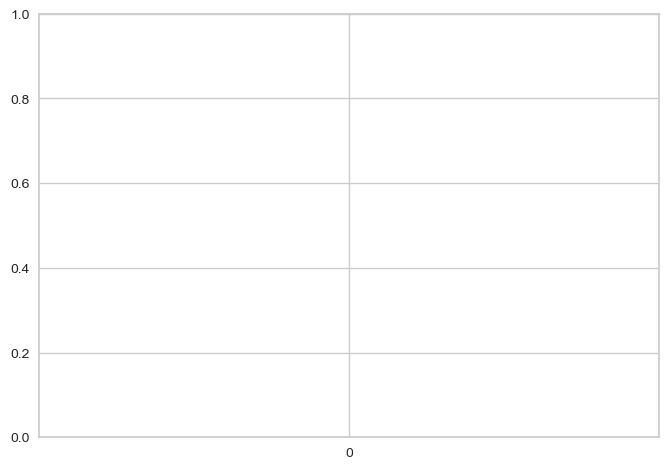

In [32]:
mean_attr_index_by_clusters = merged_df_dummies.groupby('Clusters')['attr_index'].mean().reset_index()
custom_palette = {'1': 'skyblue', '0': 'salmon' , "2": 'grey', '3': 'yellow', '4': 'pink'}

sns.barplot(x='Clusters', y='attr_index', data=mean_attr_index_by_clusters, palette =custom_palette)

plt.title('Attraction Indexes per Cluster')
plt.xlabel('Clusters')
plt.ylabel('attr_index')
sns.despine()

plt.show()

In [ ]:
mean_attr_index_by_clusters = merged_df_dummies.groupby('Clusters')['rest_index'].mean().reset_index()
custom_palette = {'1': 'skyblue', '0': 'salmon' , "2": 'grey', '3': 'yellow', '4': 'pink'}
# Create a bar plot using Seaborn
sns.barplot(x='Clusters', y='rest_index', data=mean_attr_index_by_clusters, palette =custom_palette)

# Set plot title and labels
plt.title('Restaurant Indexes per Cluster')
plt.xlabel('Clusters')
plt.ylabel('Restaurant Indexes')
sns.despine()
# Show the plot
plt.show()

In [ ]:
df_barplot=athens_weekdays.groupby('room_type')['realSum'].median()
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
sns.barplot(df_barplot, palette=custom_palette)
plt.title('Average Price per Room Type During Weekdays')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.show()

In [ ]:
df_barplot=athens_weekends.groupby('room_type')['realSum'].median()
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
sns.barplot(df_barplot, palette=custom_palette)
plt.title('Average Price per Room Type During Weekdends')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.show()